## Define Time Structure

In [89]:
import json
import random
import re
import copy

with open('relations.json', 'r') as f:
    relations = json.load(f)
assert isinstance(relations, dict)    

mapping = {1: 'Jan', 2: 'Feb', 3: "Mar", 4: "Apr", 5: "May",
           6: 'Jun', 7: 'Jul', 8: "Aug", 9: "Sep", 10: 'Oct',
           11: "Nov", 12: 'Dec'}

imapping = {v: k for k, v in mapping.items()}
imapping.update({
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,'July': 7, 'August': 8, 'September': 9, 'October': 10,
    'November': 11, 'December': 12
})
class Time(object):
    def __init__(self, time_str):
        splits = [int(_) for _ in time_str.split('-')]
        
        self.year = max(splits[0], 1)
        self.month = splits[1]
        self.date = splits[2]

        if self.month == 1 and self.date == 1:
            self.month = 0
            self.date = 0
        elif self.month == 0 or self.date == 0:
            self.month = 0
            self.date = 0
        
        assert self.year > 0
            
    def __gt__(self, other):
        assert isinstance(other, Time)
        if self.year > other.year:
            return True
        elif self.year < other.year:
            return False
        else:
            if self.month > other.month:
                return True
            elif self.month < other.month:
                return False
            else:
                if self.date > other.date:
                    return True
                else:
                    return False
    
    def __eq__(self, other):
        assert isinstance(other, Time), other
        return self.year == other.year and self.month == other.month and self.date == other.date
    
    def __lt__(self, other):
        assert isinstance(other, Time)
        if self.year < other.year:
            return True
        elif self.year > other.year:
            return False
        else:
            if self.month < other.month:
                return True
            elif self.month > other.month:
                return False
            else:
                if self.date < other.date:
                    return True
                else:
                    return False
    
    def __repr__(self):
        if self.month == 0:
            return '{}'.format(self.year)
        else:
            return '{} {}'.format(mapping[self.month], str(self.year))
    
    def __str__(self):
        return self.__repr__()
    
    @classmethod
    def parse(cls, time):
        assert isinstance(time, str)
        if ' ' not in time:
            return cls(f'{time}-0-0')
        else:
            month, year = time.split(' ')
            month = month.lower().capitalize()
            month = imapping[month]
            return cls(f'{year}-{month}-1')
    
    @classmethod
    def minus_one_year(cls, time):
        return cls('{}-{}-{}'.format(time.year - 1, time.month, time.date))

    @classmethod
    def minus_k_year(cls, time, k):
        return cls('{}-{}-{}'.format(max(time.year - k, 2), time.month, time.date))
    
    @classmethod
    def add_one_year(cls, time):
        return cls('{}-{}-{}'.format(time.year + 1, time.month, time.date))

    @classmethod
    def add_k_year(cls, time, k):
        return cls('{}-{}-{}'.format(time.year + k, time.month, time.date))      
    
    @classmethod
    def add_one_month(cls, time):
        new_time = copy.deepcopy(time)
        if new_time.month < 12:
            new_time.month += 1
            return new_time
        else:
            new_time.month = 1
            new_time.year += 1
            return new_time

def random_pop(time_range):
    cur = time_range[0]
    end = time_range[1]
    candidates = []
    cur = Time.add_one_month(cur)
    while cur < end or cur == end:
        candidates.append(cur)
        cur = Time.add_one_month(cur)

    if candidates:
        return random.choice(candidates)
    else:
        return random.choice(time_range)

def too_close(time1, time2):
    delta = (time2.year - time1.year) * 12
    delta += time2.month - time1.month
    return delta <= 2

def prop(time, first_last=None, difficulty='easy'):
    if isinstance(time, tuple) or isinstance(time, list):
        assert len(time) == 2, time
        assert isinstance(time[0], Time) and isinstance(time[1], Time)
        if too_close(time[0], time[1]):
            return 'in {}'.format(str(time[0]))
        else:
            if difficulty == 'easy':
                option = random.choice(['between'])
            elif difficulty == 'hard':
                if first_last == 'first':
                    option = random.choice(['in', 'between-subset', 'before'])
                elif first_last == 'last':
                    option = random.choice(['in', 'between-subset', 'after'])
                elif first_last is None:
                    option = random.choice(['in', 'between-subset'])
                else:
                    raise ValueError()
            else:
                raise ValueError()

            if option == 'in':
                options = ['in {}'.format(str(random_pop(time)))]
                if time[1].year // 10 > time[0].year // 10:
                    if time[1].year % 10 >= 3:
                        options.append('in early {}s'.format(time[1].year // 10 * 10))
                    if time[0].year % 10 <= 7:
                        options.append('in late {}s'.format(time[0].year // 10 * 10))
                return random.choice(options)
            elif option == 'between':
                return 'from {} to {}'.format(str(time[0]), str(time[1]))
            elif option == 'between-subset':
                x1 = random_pop(time)
                x2 = random_pop((x1, time[1]))
                return 'between {} and {}'.format(str(x1), str(x2))
            elif option == 'before':
                x = random_pop(time)
                return 'before {}'.format(str(x))
            elif option == 'after':
                x = random_pop(time)
                return 'after {}'.format(str(x))
            else:
                raise ValueError('Not Existing')
    else:
        return 'in {}'.format(str(time))

def link_2_name(string):
    string = string.replace('/wiki/', '')
    string = string.replace('_', ' ')
    return string

## Generating Train/Test Dataset

In [40]:
from tqdm import tqdm
import gzip
import json

def enc(string, split):
    string = json.dumps(string)
    if split == 'train':
        return (string + '\n').encode()
    else:
        return string + '\n'

def split_paragraphs(paras):
    # Process the data
    ctxs = []
    buffer = {"title": paras[0], "text": ""}
    for para in paras[1:]:
        if para[0].isupper() and len(para.split(' ')) <= 4:
            if len(buffer["text"].split(' ')) > 15:
                ctxs.append(buffer)
            buffer = {"title": para.strip(' .'), "text": ""}
        else:
            if len(buffer['text'].split(' ')) + len(para.split(' ')) > 100:
                if len(buffer['text'].split(' ')) > 15:
                    ctxs.append(buffer)
                    buffer = {"title": ctxs[-1]['title'], "text": ""}
                tokens = para.split(' ')
                for j in range(0, len(tokens), 100):
                    buffer['text'] = ' '.join(tokens[j: j + 100])
                    ctxs.append(buffer)
                    buffer = {"title": ctxs[-1]['title'], "text": ""}
            else:
                buffer['text'] += ' ' + para

    if buffer['text']:
        ctxs.append(buffer)
    ctxs = ctxs[:100]
    return ctxs

### Standard Train/Dev/Test

In [ ]:
splits = ['train', 'dev', 'test']
difficulties = ['easy', 'hard']

for split in splits:
    with open(f'dataset/annotated_{split}.json', 'r') as f:
        data = json.load(f)
    for difficulty in difficulties:
        if split == 'train':
            file = gzip.open(f'dataset/{split}.{difficulty}.json.gzip', 'wb')
        else:
            file = open(f'dataset/{split}.{difficulty}.json', 'w')
        
        for d in tqdm(data, desc=f'{split}-{difficulty}'):
            assert isinstance(d['type'], str)
            
            paragraphs = split_paragraphs(d['paras'])
            assert isinstance(paragraphs, list)
            
            templates = relations[d['type']]['template']
            template = random.choice(templates)
            template = template.replace('$1', link_2_name(d['link']))

            qas = []
            for i, entry in enumerate(d['questions']):
                assert len(re.findall('\?$', template)) == 1, template
                time_step = [Time.parse(entry[0][0]), Time.parse(entry[0][1])]

                assert isinstance(entry[1], list), entry[1]
                assert isinstance(entry[1][0], dict), entry[1]
                
                if i == 0:
                    specifier = prop(time_step, 'first', difficulty)
                elif i == len(d['questions']) - 1:
                    specifier = prop(time_step, 'last', difficulty)
                else:
                    specifier = prop(time_step, None, difficulty)

                if '$4' in template:
                    question = template.replace('$4', specifier)
                elif '$2' in template:
                    question = template.replace('$2', specifier)
                else:
                    raise "It's not a template"
                qas.append((question, entry[1]))

            while len(qas) < 3 and difficulty == 'hard' and relations[d['type']]['mode'] == 'accumulate':                
                start_ = Time.parse(d['questions'][0][0][0])
                end_ = Time.parse(d['questions'][-1][0][1])
                
                options = [(Time.minus_k_year(start_, 10), start_)]
                
                recent = Time('2020-0-0')
                if end_ < recent:
                    options.append((end_, min(recent, Time.add_k_year(end_, 10))))

                choice = random.choice(range(len(options)))
                if choice == 0:
                    specifier = prop(options[0], 'first', difficulty)
                else:
                    specifier = prop(options[1], 'last', difficulty)
                
                assert '$4' in template
                question = template.replace('$4', specifier)
                qas.append((question, [{'para': 0, 'from': 0, 'end': 0, 'answer': ''}]))
            
            for q_index, qs in enumerate(qas):
                answers = [_['answer'] for _ in qs[1]]
                if split in ['dev', 'test']:
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']),
                           'targets': answers, 'paragraphs': paragraphs}
                    q_index += 1
                    file.write(enc(tmp, split))
                else:
                    from_ = []
                    end_ = []
                    offset = [0]
                    for para in d['paras'][:-1]:
                        offset.append(len(para) + 1 + offset[-1])
                    for ans in qs[1]:
                        from_.append(offset[ans['para']] + ans['from'])
                        end_.append(offset[ans['para']] + ans['end'])
                    
                    passage = ' '.join(d['paras'])
                    assert passage[from_[0]: end_[0]] == qs[1][0]['answer'], passage[from_[0]: end_[0]] + ' # ' + qs[1][0]['answer']
                    
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']), 
                           'targets': answers, 'from': from_, 'end': end_, 'paragraphs': paragraphs}
                    file.write(enc(tmp, split))
        
        file.close()

## Generaing easy/hard Human rewritten questions

In [79]:
string = 'What racing sport did Sergio Perez play from May 2005 to 2006?'
re.search(r'(from|From) (\S+|\S+ \d+) to', string).group(2)

'May 2005'

In [106]:
import json

import re

def extract_time_span(string):
    if 'from ' in string.lower() and ' to ' in string.lower():
        #print(string)
        match = re.search(r'(from|From) (\S+|\S+ \d+) to', string)
        start = match.group(2)
        match = re.search(r'(from|From) (\S+|\S+ \d+) to (\S+ \d+|\d+)\b', string)
        end = match.group(3)
        template = re.sub(r'(from|From) (\S+|\S+ \d+) to (\S+ \d+|\d+)\b', '$4', string)
        assert start is not None, string
        assert end is not None, string
        return start, end, template
    else:
        return None, None, string

splits = ['train', 'test']
difficulties = ['easy', 'hard']
extract_succ, extract_fail = 0, 0
for split in splits:
    with open(f'dataset/human_annotated_{split}.json', 'r') as f:
        data = json.load(f)
    for difficulty in difficulties:
        if split == 'train':
            file = gzip.open(f'dataset/human_{split}.{difficulty}.json.gzip', 'wb')
        else:
            file = open(f'dataset/human_{split}.{difficulty}.json', 'w')
        
        for d in tqdm(data, desc=f'{split}-{difficulty}'):
            assert isinstance(d['type'], str)
            
            paragraphs = split_paragraphs(d['paras'])
            assert isinstance(paragraphs, list)

            qas = []
            for i, entry in enumerate(d['questions']):
                start, end, question = extract_time_span(entry[0])
                if start and end:
                    extract_succ += 1
                    time_step = [Time.parse(start), Time.parse(end)]
                    if i == 0:
                        specifier = prop(time_step, 'first', difficulty)
                    elif i == len(d['questions']) - 1:
                        specifier = prop(time_step, 'last', difficulty)
                    else:
                        specifier = prop(time_step, None, difficulty)
                    question = question.replace('$4', specifier)
                else:
                    extract_fail += 1

                assert isinstance(entry[1], list), entry[1]
                assert isinstance(entry[1][0], dict), entry[1]
                qas.append((question, entry[1]))
            
            for q_index, qs in enumerate(qas):
                answers = [_['answer'] for _ in qs[1]]
                if split in ['dev', 'test']:
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']),
                           'targets': answers, 'paragraphs': paragraphs}
                    q_index += 1
                    file.write(enc(tmp, split))
                else:
                    from_ = []
                    end_ = []
                    offset = [0]
                    for para in d['paras'][:-1]:
                        offset.append(len(para) + 1 + offset[-1])
                    for ans in qs[1]:
                        from_.append(offset[ans['para']] + ans['from'])
                        end_.append(offset[ans['para']] + ans['end'])
                    
                    passage = ' '.join(d['paras'])
                    assert passage[from_[0]: end_[0]] == qs[1][0]['answer'], passage[from_[0]: end_[0]] + ' # ' + qs[1][0]['answer']
                    
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']), 
                           'targets': answers, 'from': from_, 'end': end_, 'paragraphs': paragraphs}
                    file.write(enc(tmp, split))
        
        file.close()

print('succ', extract_succ, 'fail', extract_fail)

test-hard: 100%|██████████| 257/257 [00:02<00:00, 120.17it/s]

succ 3876 fail 444


### Sensitivity Analysis

In [35]:
splits = ['dev']
difficulties = ['hard']
repeat = 3
sample_size = 500

for split in splits:
    with open(f'dataset/annotated_{split}.json', 'r') as f:
        data = json.load(f)
    
    for difficulty in difficulties:
        file = open(f'dataset/{split}.{difficulty}.repeat.json', 'w')
        
        for d in tqdm(data[:sample_size], desc=f'{split}-{difficulty}'):
            assert isinstance(d['type'], str)
            
            paragraphs = split_paragraphs(d['paras'])
            assert isinstance(paragraphs, list)
            
            templates = relations[d['type']]['template']
            template = random.choice(templates)
            template = template.replace('$1', link_2_name(d['link']))

            qas = []
            for i, entry in enumerate(d['questions']):
                assert len(re.findall('\?$', template)) == 1, template
                time_step = [Time.parse(entry[0][0]), Time.parse(entry[0][1])]

                assert isinstance(entry[1], list), entry[1]
                assert isinstance(entry[1][0], dict), entry[1]
                
                if '$4' in template:
                    for _ in range(3):
                        specifier = prop(time_step, None, difficulty)
                        question = template.replace('$4', specifier)
                        qas.append((question, entry[1]))
            
            for q_index, qs in enumerate(qas):
                answers = [_['answer'] for _ in qs[1]]
                if split in ['dev', 'test']:
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']),
                           'targets': answers, 'paragraphs': paragraphs}
                    q_index += 1
                    file.write(enc(tmp, split))
                else:
                    from_ = []
                    end_ = []
                    offset = [0]
                    for para in d['paras'][:-1]:
                        offset.append(len(para) + 1 + offset[-1])
                    for ans in qs[1]:
                        from_.append(offset[ans['para']] + ans['from'])
                        end_.append(offset[ans['para']] + ans['end'])
                    
                    passage = ' '.join(d['paras'])
                    assert passage[from_[0]: end_[0]] == qs[1][0]['answer'], passage[from_[0]: end_[0]] + ' # ' + qs[1][0]['answer']
                    
                    tmp = {'idx': d['index'] + '#' + str(q_index), 'question': qs[0], 'context': ' '.join(d['paras']), 
                           'targets': answers, 'from': from_, 'end': end_, 'paragraphs': paragraphs}
                    file.write(enc(tmp, split))
        
        file.close()

dev-hard: 100%|██████████| 500/500 [00:09<00:00, 50.79it/s]


In [38]:
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-12/23-30-48/output.json') as f:
    predictions = json.load(f)

consistent, inconsistent = 0, 0
answers = []
for k in predictions:
    if len(answers) < 3:
        answers.append(predictions[k])
    else:
        if len(set(answers)) == 1:
            consistent += 1
        else:
            inconsistent += 1
        answers = [predictions[k]]

print(consistent, inconsistent, consistent / (consistent + inconsistent))

1278 632 0.669109947643979


## Data Analysis

In [ ]:
import json

data = []
with open('dataset/dev.hard.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

answerable, na = 0, 0
for d in data:
    if d['targets'] == ['']:
        na += 1
    else:
        answerable += 1
        
print(na, answerable)

In [ ]:
import json
from utils import get_raw_scores

data = []
with open('dataset/dev.easy.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))

reference = {}
context = {}
for entry in data:
    reference[entry['idx']] = entry['targets']
    context[entry['idx']] = (entry['question'], entry['context'])
        
print('FiD-easy')
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/13-49-48/output.json') as f:
    pred = json.load(f)

print(get_raw_scores(pred, reference))

from yattag import Doc

doc, tag, text = Doc(
    defaults = {
            'title': 'TSQA Prediction Visualization',
            'contact_message': 'Prediction Visualization!'
        },
).tagtext()

css = """
.collapsible {
  background-color: #777;
  color: white;
  cursor: pointer;
  padding: 18px;
  width: 100%;
  border: none;
  text-align: left;
  outline: none;
  font-size: 15px;
}

.active, .collapsible:hover {
  background-color: #555;
}

.content {
  padding: 0 18px;
  display: none;
  overflow: hidden;
  background-color: #f1f1f1;
}
"""

with doc.tag('style', type='text/css'):
    doc.asis(css)
    
done = set()
results = {'context': '', 'question': [], 'pred': [], 'groundtruth': []}
with tag('html'):
    with tag('body'):
        for k in list(reference.keys())[:500]:
            name = k.split('#')[0]
            if name not in done:
                if results['context']:
                    with tag('button', type='button', klass='collapsible'):
                        text(f'open {name}')

                    with tag('div', klass='content'):
                        with tag('p', id = 'main'):
                            text(results['context'])
                        for q, p, g in zip(results['question'], results['pred'], results['groundtruth']):
                            with tag('p', id = 'main'):
                                text(q)
                            with tag('p', id = 'main'):
                                text(p)
                            with tag('p', id = 'main'):
                                text(g)

                results = {'context': '', 'question': [], 'pred': [], 'groundtruth': []}
                results['context'] = context[k][1]
                done.add(name)
            
            if pred[k] not in reference[k]:
                results['question'].append(context[k][0])
                results['pred'].append(f'Pred: {pred[k]}')
                ref = ' ; '.join(reference[k])
                results['groundtruth'].append(f'Reference: {ref}')

    script = """
    var coll = document.getElementsByClassName("collapsible");
    var i;

    for (i = 0; i < coll.length; i++) {
      coll[i].addEventListener("click", function() {
        this.classList.toggle("active");
        var content = this.nextElementSibling;
        if (content.style.display === "block") {
          content.style.display = "none";
        } else {
          content.style.display = "block";
        }
      });
    }
    """
    with tag('script'):
        doc.asis(script)

result = doc.getvalue()
#print(result)
with open('main.html', 'w') as f:
    f.write(result)
#print(get_raw_scores(pred, reference))

In [30]:
def print_only_one(pred):
    from collections import defaultdict

    outputs = defaultdict(set)
    for k in pred:
        name = re.sub(r'#[0-9]$', '', k)
        outputs[name].add(pred[k])
    
    average = []
    only_one = 0
    for k in outputs:
        if len(outputs[k]) == 1:
            only_one += 1
        average.append(len(outputs[k]))
    print(only_one, len(outputs), sum(average) / len(average))

# Untrained NQ prediction on TimeQA-Hard
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-12/16-04-34/output.json') as f:
    pred = json.load(f)
print('NQ hard')
print_only_one(pred)

with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/15-20-21/output.json') as f:
    pred = json.load(f)
print('FiD hard')
print_only_one(pred)

NQ hard
107 750 2.9186666666666667
FiD hard
68 750 3.084


In [20]:
import json
from utils import get_raw_scores
import re

data = []
with open('dataset/dev.easy.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

reference = {}
context = {}
for entry in data:
    reference[entry['idx']] = entry['targets']
    context[entry['idx']] = (entry['question'], entry['context'])
        
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/13-49-48/output.json') as f:
    pred = json.load(f)

mentioned = []
partial_mentioned = []
not_mentioned = []
for k in reference:
    question, document = context[k]
    time = extract_year(question)
    #if isinstance(time, str):
    #    if time in document:
    #        mentioned.append(get_raw_scores({k: pred[k]}, {k: reference[k]})['exact'])
    #    else:
    #        not_mentioned.append(get_raw_scores({k: pred[k]}, {k: reference[k]})['exact'])
    #else:
    #assert len(time) == 2
    if all([t in document for t in time]):
        mentioned.append(get_raw_scores({k: pred[k]}, {k: reference[k]})['exact'])
    #elif time[0] in document or time[1] in document:
    #    partial_mentioned.append(get_raw_scores({k: pred[k]}, {k: reference[k]})['exact'])
    else:
        not_mentioned.append(get_raw_scores({k: pred[k]}, {k: reference[k]})['exact'])

print(sum(mentioned) / len(mentioned), len(mentioned))
#print(sum(partial_mentioned) / len(partial_mentioned), len(partial_mentioned))
print(sum(not_mentioned) / len(not_mentioned), len(not_mentioned))

63.45785440613027 2088
50.91103965702037 933


In [17]:
import re

def extract_year(string):
    if re.search(r'from ([0-9]+|\S+ [0-9]+) to ([0-9]+|\S+ [0-9]+)', string):
        match = re.search(r'from ([0-9]+|\S+ [0-9]+) to ([0-9]+|\S+ [0-9]+)', string)
        outputs = []
        outputs.extend(match.group(1).split(' '))
        outputs.extend(match.group(2).split(' '))
        return outputs
    elif re.search(r'in ([0-9]+|\S+ [0-9]+)', string):
        match = re.search(r'in ([0-9]+|\S+ [0-9]+)', string).group(1)
        return match.split(' ')
    else:
        raise ValueError(string)
        return None

In [39]:
import json
from utils import get_raw_scores

data = []
with open('dataset/dev.hard.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))

answerable = {}
unanswerable = {}
for entry in data:
    if entry['targets'] == ['']:
        unanswerable[entry['idx']] = entry['targets']
    else:
        answerable[entry['idx']] = entry['targets']

print('BigBird-hard')
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/12-35-13/output.json') as f:
    pred = json.load(f)
print('-answerable')
print(get_raw_scores(pred, answerable))
print('-unanswerable')
print(get_raw_scores(pred, unanswerable))
print()

print('FiD-hard')
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/15-20-21/output.json') as f:
    pred = json.load(f)
print('-answerable')
print(get_raw_scores(pred, answerable))
print('-unanswerable')
print(get_raw_scores(pred, unanswerable))
print()

data = []
with open('dataset/dev.easy.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))

answerable = {}
unanswerable = {}
for entry in data:
    if entry['targets'] == ['']:
        unanswerable[entry['idx']] = entry['targets']
    else:
        answerable[entry['idx']] = entry['targets']

print('BigBird-Easy')
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/13-28-41/output.json') as f:
    pred = json.load(f)

print('answerable')
print(get_raw_scores(pred, answerable))
print('unanswerable')
print(get_raw_scores(pred, unanswerable))
print()

print('FiD-Easy')
with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/13-49-48/output.json') as f:
    pred = json.load(f)

print('answerable')
print(get_raw_scores(pred, answerable))
print('unanswerable')
print(get_raw_scores(pred, unanswerable))

3087
BigBird-hard
-answerable
OrderedDict([('exact', 43.97905759162304), ('f1', 54.111246175841394), ('total', 3087)])
-unanswerable
OrderedDict([('exact', 20.82324455205811), ('f1', 20.82324455205811), ('total', 3087)])

FiD-hard
-answerable
OrderedDict([('exact', 46.37247569184742), ('f1', 55.97945613493895), ('total', 3087)])
-unanswerable
OrderedDict([('exact', 38.983050847457626), ('f1', 38.983050847457626), ('total', 3087)])

3021
BigBird-Easy
answerable
OrderedDict([('exact', 52.169035153328345), ('f1', 62.086324516259914), ('total', 3021)])
unanswerable
OrderedDict([('exact', 36.887608069164266), ('f1', 36.887608069164266), ('total', 3021)])

FiD-Easy
answerable
OrderedDict([('exact', 60.770381451009726), ('f1', 69.1346009962096), ('total', 3021)])
unanswerable
OrderedDict([('exact', 50.43227665706052), ('f1', 50.43227665706052), ('total', 3021)])


In [ ]:
import datasets
import json
from utils import get_raw_scores

data = []
with open('dataset/dev.hard.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))

reference = {}
context = {}
for entry in data:
    reference[entry['idx']] = entry['targets']
    context[entry['idx']] = entry['context']

def print_graph(name, pred, reference, context):
    from collections import defaultdict
    score = defaultdict(list)

    width = 400
    for k in pred:
        tok_length = len(context[k].split(' '))
        em = get_raw_scores({k: pred[k]}, {k: reference[k]})['exact']
        assert isinstance(em, float)
        score[tok_length // width].append(em)

    for k in score:
        score[k] = sum(score[k]) / len(score[k])

    ranked_score = sorted(score.items(), key=lambda x:x[0])
    print(ranked_score)

    import matplotlib.pyplot as plt
    #print(get_raw_scores(pred, reference))

    x = [str(_[0] * width) for _ in ranked_score]
    y = [_[1] for _ in ranked_score]
    if 'BigBird' in name:
        plt.bar(x, y, color='lemonchiffon', edgecolor = "black")
    else:
        plt.bar(x, y, color='lightgreen', edgecolor = "black")
    plt.xlabel('Input Token length',  fontsize=12)
    plt.ylabel('EM')
    plt.xticks(rotation=90)
    plt.title(f'{name} EM score vs. Document Length', fontsize=15)
    plt.tight_layout()
    plt.savefig(name + '.jpg', dpi=200)
    plt.show()
    plt.clf()

with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/12-35-13/output.json') as f:
    pred = json.load(f)

print_graph('BigBird-hard', pred, reference, context)


with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/15-20-21/output.json') as f:
    pred = json.load(f)

print_graph('FiD-hard', pred, reference, context)

3087
{'P39': 33.65231259968102, 'P54': 51.17370892018779, 'P108': 38.40304182509506, 'P6': 45.833333333333336, 'P69': 39.39393939393939, 'P26': 37.77777777777778, 'P937': 29.78723404255319, 'P488': 54.205607476635514, 'P551': 22.641509433962263, 'P1435': 40.74074074074074, 'P102': 36.36363636363637, 'P371': 28.571428571428573, 'P463': 46.3768115942029, 'P276': 36.666666666666664, 'P6087': 57.4468085106383, 'P17': 37.5, 'P127': 32.35294117647059, 'P137': 36.666666666666664, 'P4791': 24.0, 'P2962': 61.76470588235294, 'P1448': 37.80487804878049, 'P1037': 57.89473684210526}


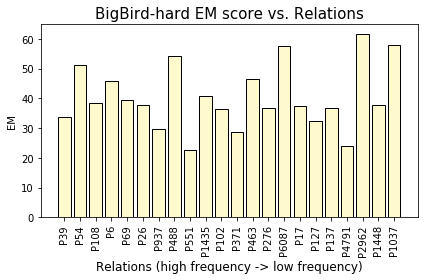

{'P39': 34.2902711323764, 'P54': 54.929577464788736, 'P108': 40.3041825095057, 'P6': 47.916666666666664, 'P69': 44.94949494949495, 'P26': 62.22222222222222, 'P937': 42.5531914893617, 'P488': 58.87850467289719, 'P551': 37.735849056603776, 'P1435': 44.44444444444444, 'P102': 36.36363636363637, 'P371': 38.095238095238095, 'P463': 63.768115942028984, 'P276': 20.0, 'P6087': 57.4468085106383, 'P17': 40.625, 'P127': 30.88235294117647, 'P137': 26.666666666666668, 'P4791': 72.0, 'P2962': 61.76470588235294, 'P1448': 40.24390243902439, 'P1037': 73.6842105263158}


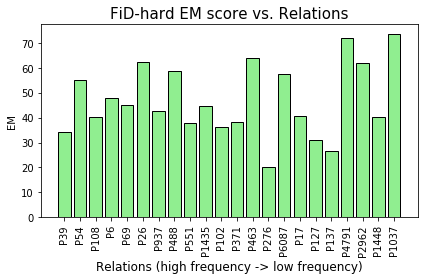

<Figure size 432x288 with 0 Axes>

In [24]:
import datasets
import json
from utils import get_raw_scores
import matplotlib.pyplot as plt

data = []
with open('dataset/dev.hard.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))

reference = {}
context = {}
for entry in data:
    reference[entry['idx']] = entry['targets']
    context[entry['idx']] = entry['idx'].split('#')[1]

def print_graph(name, pred, reference, context):
    from collections import defaultdict
    score = defaultdict(list)

    for k in pred:
        em = get_raw_scores({k: pred[k]}, {k: reference[k]})['exact']
        assert isinstance(em, float)
        score[context[k]].append(em)
    
    new_score = {}
    for k in score:
        if len(score[k]) > 20:
            new_score[k] = sum(score[k]) / len(score[k])
    print(new_score)

    x = new_score.keys()
    y = new_score.values()
    if 'BigBird' in name:
        plt.bar(x, y, color='lemonchiffon', edgecolor = "black")
    else:
        plt.bar(x, y, color='lightgreen', edgecolor = "black")
    plt.xlabel('Relations (high frequency -> low frequency)', fontsize=12)
    plt.ylabel('EM')
    plt.xticks(rotation=90)
    plt.title(f'{name} EM score vs. Relations', fontsize=15)
    plt.tight_layout()
    plt.savefig(name + '.relation.jpg', dpi=200)
    plt.show()
    plt.clf()

with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/12-35-13/output.json') as f:
    pred = json.load(f)

print_graph('BigBird-hard', pred, reference, context)


with open('/data2/wenhu/Time-Sensitive-QA/outputs/2021-08-08/15-20-21/output.json') as f:
    pred = json.load(f)

print_graph('FiD-hard', pred, reference, context)